**Testing SNR Code:**

In [1]:
import Labber
import os
import sys
from fitTools.utilities import Watt2dBm, dBm2Watt, VNA2dBm

from twpa_tune_up_helper_functions import *


/Users/shanto/miniforge3/envs/lfl_qp/lib/python3.9/site-packages/qtpy/__init__.py:214: RuntimeWarning: Selected binding "pyqt5" could not be found, using "pyside6"
  warnings.warn('Selected binding "{}" could not be found, '


In [2]:
labber_data_file = "data/TWPA_Tune_Up_91923.hdf5"

In [14]:
std_highSNR = 1.75 # cut off point
std_SNR = 2.5 # for noise floor

lf = Labber.LogFile(labber_data_file)

power_channel_name = "10002F25 - Power"
freq_channel_name = "10002F25 - Frequency"
SA_channel_name = 'HP Spectrum Analyzer - Signal'

pump_power = lf.getData(name = power_channel_name)
pump_freq = lf.getData(name = freq_channel_name)  

signal = lf.getData(name = SA_channel_name)
linsig = dBm2Watt(signal)

SAxdata, SAydata = lf.getTraceXY(y_channel=SA_channel_name, entry=0) # gives last trace from SA

In [16]:
signal[0] - SAydata

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

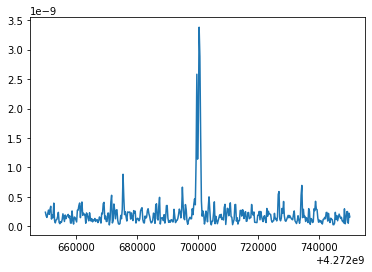

In [32]:
plt.plot(SAxdata,dBm2Watt(signal[0]))
plt.show()

In [52]:
snrs, max_signal, noise_floor = get_signal_stats(dBm2Watt(signal[0]),std_dev=3)

In [53]:
snrs, max_signal, noise_floor

(11.112233007481358, -54.71, -65.82223300748136)

In [55]:
def get_SNR_james(signal, SAxdata, cutOff=10e3):
    max_ind = np.argmax(signal)
    max_val = np.max(signal)
    mask = np.logical_or(SAxdata < SAxdata[max_ind]-cutOff, SAxdata > SAxdata[max_ind]+cutOff)
    noisetemp = signal[mask]
    noise_floor = np.mean(noisetemp)
    snr = Watt2dBm(max_val) - Watt2dBm(noise_floor)
    noise_floor = Watt2dBm(noise_floor)
    max_signal = Watt2dBm(max_val)
    return [snr, max_signal, noise_floor]


In [56]:
get_SNR_james(dBm2Watt(signal[0]),SAxdata)

12.87779341263721 -54.71 -67.58779341263721


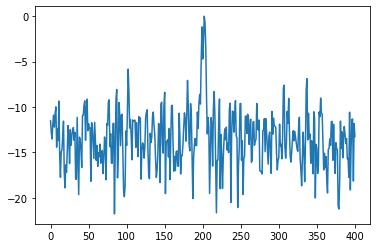